## VaR Portofolio


=========== PORTFOLIO RISK RESULTS ===========
Mean PL           : 2,529,342,034
Std Dev           : 95,432,298,172

--- VaR 95% ---
Historical VaR95  : -128,519,797,271
Parametric VaR95  : -154,442,819,743

--- ES 95% ---
Historical ES95   : -201,330,935,822
Parametric ES95   : -194,320,081,655



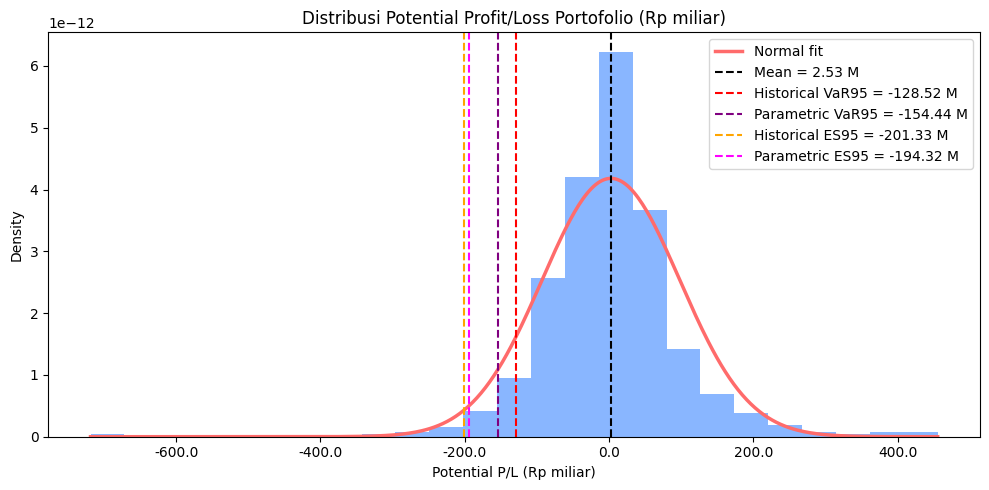

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. READ DATA
# =========================

file_path = "PL_instruments.xlsx"
df = pd.read_excel(file_path)

# Adjust column names to match your Excel
FI_COL   = "PL_FI"
STK_COL  = "PL_Saham_Produktif"
MF_COL   = "PL_RD"

for col in [FI_COL, STK_COL, MF_COL]:
    if col not in df.columns:
        raise ValueError(f"Kolom {col} tidak ditemukan di file Excel.")

# =========================
# 2. COMBINED PORTFOLIO PL
# =========================

df["PL_Total"] = df[FI_COL] + df[STK_COL] + df[MF_COL]
series = df["PL_Total"].dropna()

# =========================
# 3. RISK METRICS
# =========================

alpha = 0.95           # 95% VaR (left tail)
z_95 = norm.ppf(1 - alpha)   # = -1.645

mu = series.mean()
sigma = series.std(ddof=1)

# ---------- HISTORICAL VAR ----------
VaR95_hist = series.quantile(1 - alpha)

# ---------- PARAMETRIC VAR ----------
# VaR = μ + zσ (z ~ -1.645)
VaR95_param = mu + z_95 * sigma

# ---------- EXPECTED SHORTFALL (Historical) ----------
losses = -series
loss_q = np.quantile(losses, alpha)
ES95_hist = -losses[losses >= loss_q].mean()

# ---------- PARAMETRIC ES (Optional) ----------
ES95_param = mu - sigma * norm.pdf(norm.ppf(1 - alpha)) / (1 - alpha)



# =========================
# 4. PRINT RESULTS
# =========================

print("\n=========== PORTFOLIO RISK RESULTS ===========")
print(f"Mean PL           : {mu:,.0f}")
print(f"Std Dev           : {sigma:,.0f}")

print("\n--- VaR 95% ---")
print(f"Historical VaR95  : {VaR95_hist:,.0f}")
print(f"Parametric VaR95  : {VaR95_param:,.0f}")

print("\n--- ES 95% ---")
print(f"Historical ES95   : {ES95_hist:,.0f}")
print(f"Parametric ES95   : {ES95_param:,.0f}")
print("==============================================\n")


# =========================
# 5. PLOT DISTRIBUTION
# =========================

def miliar_fmt(x, pos):
    return f"{x/1e9:,.1f}"

fig, ax = plt.subplots(figsize=(10, 5))

# Histogram
ax.hist(series, bins=25, density=True, alpha=0.6, color="#3a86ff")

# Normal curve
xmin, xmax = series.min(), series.max()
x = np.linspace(xmin, xmax, 400)
y = norm.pdf(x, mu, sigma)
ax.plot(x, y, linewidth=2.5, color="#ff6b6b", label="Normal fit")

# Lines for mean and VaR
ax.axvline(mu, color="black", linestyle="--", label=f"Mean = {mu/1e9:.2f} M")
ax.axvline(VaR95_hist, color="red", linestyle="--", label=f"Historical VaR95 = {VaR95_hist/1e9:.2f} M")
ax.axvline(VaR95_param, color="purple", linestyle="--", label=f"Parametric VaR95 = {VaR95_param/1e9:.2f} M")
ax.axvline(ES95_hist, color="orange", linestyle="--", label=f"Historical ES95 = {ES95_hist/1e9:.2f} M")
ax.axvline(ES95_param, color="magenta", linestyle="--", label=f"Parametric ES95 = {ES95_param/1e9:.2f} M")

ax.xaxis.set_major_formatter(FuncFormatter(miliar_fmt))
ax.set_title("Distribusi Potential Profit/Loss Portofolio (Rp miliar)")
ax.set_xlabel("Potential P/L (Rp miliar)")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# ==================================================
# 1. READ DATA
# ==================================================

file_path = "PL_instruments.xlsx"       # ganti sesuai nama file
df = pd.read_excel(file_path)

# Kolom PL untuk masing-masing kelas aset (Rp, bisa + / -)
# SESUAIKAN dengan header di file kamu
asset_cols = ["PL_FI", "PL_Saham_Produktif", "PL_RD"]

for c in asset_cols:
    if c not in df.columns:
        raise ValueError(f"Kolom {c} tidak ditemukan di file Excel.")

# Hanya ambil baris yang lengkap untuk ketiga aset
pl_assets = df[asset_cols].dropna()

# ==================================================
# 2. GLOBAL SETTINGS
# ==================================================

alpha = 0.95                 # level kepercayaan 95%
z = norm.ppf(alpha)          # z_0.95 ≈ 1.645 (positif)
conf_str = f"{int(alpha*100)}%"

# ==================================================
# 3. TOP-DOWN: PORTFOLIO PL LANGSUNG
# ==================================================

# Portofolio PL = jumlah PL dari 3 kelas aset (per hari)
pl_total = pl_assets.sum(axis=1)

mu_td = pl_total.mean()
sigma_td = pl_total.std(ddof=1)

# Historical VaR (left tail) → ambil nilai negatif lalu jadikan positif
VaR95_hist = -pl_total.quantile(1 - alpha)

# Parametric VaR (dengan asumsi normal) → |VaR| = z * σ
VaR95_param_td = z * sigma_td

# ==================================================
# 4. BOTTOM-UP PARAMETRIC: GUNAKAN σ & KORELASI
# ==================================================

# Standar deviasi masing-masing kelas aset
sigma_vec = pl_assets.std(ddof=1)              # panjang = 3

# Kovarians & korelasi antar kelas aset
cov_mat  = pl_assets.cov()
corr_mat = pl_assets.corr()

# Bobot portofolio dalam ruang PL; karena PL sudah full eksposur,
# kita bisa pakai vektor ones (portofolio = PL1 + PL2 + PL3)
w = np.ones(len(asset_cols))

# (a) Portfolio sigma dari kovarians: σ_p^2 = w' Σ w
sigma_p_bottom = np.sqrt(w @ cov_mat.values @ w.T)
VaR95_param_bottom = z * sigma_p_bottom

# (b) Portfolio VaR dari formula VaR_i & korelasi (general n-assets)
#    VaR_i = z * σ_i  (nilai positif)
VaR_i = z * sigma_vec          # vektor VaR stand-alone (positif)
VaR95_param_corr = np.sqrt(VaR_i.values @ corr_mat.values @ VaR_i.values)

# ==================================================
# 5. RINGKASAN HASIL
# ==================================================

print("\n================ PORTFOLIO VAR COMPARISON ================")
print(f"Jumlah observasi        : {len(pl_total)}")
print(f"Mean PL (Rp)            : {mu_td:,.0f}")
print(f"Sigma PL (Rp)           : {sigma_td:,.0f}")
print(f"Level kepercayaan       : {conf_str}")
print("----------------------------------------------------------")
print("TOP-DOWN (langsung dari PL_total)")
print(f"  Historical VaR{conf_str:>4}   : {VaR95_hist:,.0f}")
print(f"  Parametric VaR{conf_str:>4}   : {VaR95_param_td:,.0f}")
print("----------------------------------------------------------")
print("BOTTOM-UP PARAMETRIC (σ & korelasi antar kelas aset)")
print(f"  VaR via covariance Σ   : {VaR95_param_bottom:,.0f}")
print(f"  VaR via VaR_i & ρ_ij   : {VaR95_param_corr:,.0f}")
print("----------------------------------------------------------")
print("STAND-ALONE PARAMETRIC VaR PER KELAS ASET")
for name, v in zip(asset_cols, VaR_i):
    print(f"  {name:<20}: {v:,.0f}")
print("----------------------------------------------------------")
print(f"Naive SUM VaR_i (tanpa diversifikasi) : {VaR_i.sum():,.0f}")
print("==========================================================\n")



================ PORTFOLIO VAR COMPARISON ================
Jumlah observasi        : 557
Mean PL (Rp)            : 2,529,342,034
Sigma PL (Rp)           : 95,432,298,172
Level kepercayaan       : 95%
----------------------------------------------------------
TOP-DOWN (langsung dari PL_total)
  Historical VaR 95%   : 128,519,797,271
  Parametric VaR 95%   : 156,972,161,777
----------------------------------------------------------
BOTTOM-UP PARAMETRIC (σ & korelasi antar kelas aset)
  VaR via covariance Σ   : 156,972,161,777
  VaR via VaR_i & ρ_ij   : 156,972,161,777
----------------------------------------------------------
STAND-ALONE PARAMETRIC VaR PER KELAS ASET
  PL_FI               : 7,269,580,351
  PL_Saham_Produktif  : 84,351,514,621
  PL_RD               : 92,066,745,280
----------------------------------------------------------
Naive SUM VaR_i (tanpa diversifikasi) : 183,687,840,252



## Historical VaR Portofolio


=========== PORTFOLIO RISK RESULTS ===========
Mean PL           : 2,529,342,034
Std Dev           : 95,432,298,172

--- VaR 95% ---
Historical VaR95  : -128,519,797,271
Parametric VaR95  : -154,442,819,743

--- ES 95% ---
Historical ES95   : -201,330,935,822
Parametric ES95   : -194,320,081,655



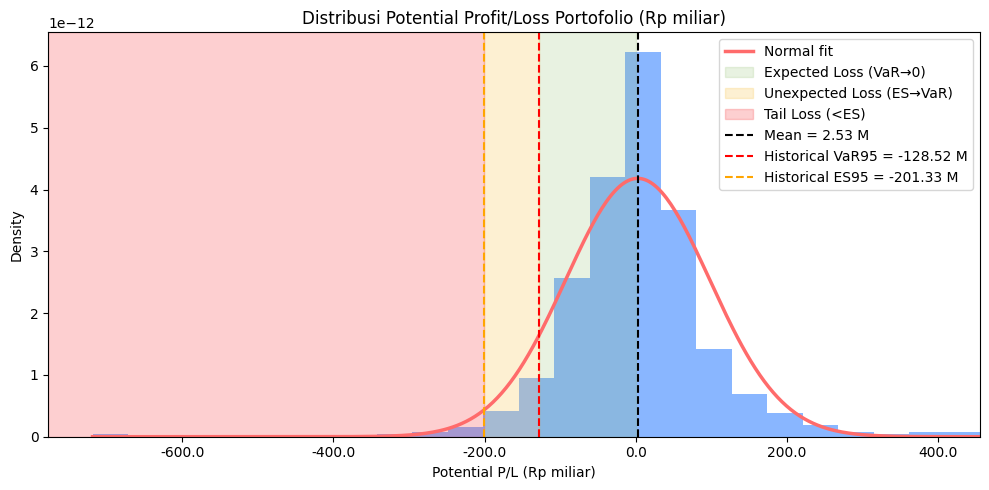

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

# =========================
# 1. READ DATA
# =========================

file_path = "PL_instruments.xlsx"
df = pd.read_excel(file_path)

# Adjust column names to match your Excel
FI_COL   = "PL_FI"
STK_COL  = "PL_Saham_Produktif"
MF_COL   = "PL_RD"

for col in [FI_COL, STK_COL, MF_COL]:
    if col not in df.columns:
        raise ValueError(f"Kolom {col} tidak ditemukan di file Excel.")

# =========================
# 2. COMBINED PORTFOLIO PL
# =========================

df["PL_Total"] = df[FI_COL] + df[STK_COL] + df[MF_COL]
series = df["PL_Total"].dropna()

# =========================
# 3. RISK METRICS
# =========================

alpha = 0.95           # 95% VaR (left tail)
z_95 = norm.ppf(1 - alpha)   # = -1.645

mu = series.mean()
sigma = series.std(ddof=1)

# ---------- HISTORICAL VAR ----------
VaR95_hist = series.quantile(1 - alpha)

# ---------- PARAMETRIC VAR ----------
# VaR = μ + zσ (z ~ -1.645)
VaR95_param = mu + z_95 * sigma

# ---------- EXPECTED SHORTFALL (Historical) ----------
losses = -series
loss_q = np.quantile(losses, alpha)
ES95_hist = -losses[losses >= loss_q].mean()

# ---------- PARAMETRIC ES (Optional) ----------
ES95_param = mu - sigma * norm.pdf(norm.ppf(1 - alpha)) / (1 - alpha)



# =========================
# 4. PRINT RESULTS
# =========================

print("\n=========== PORTFOLIO RISK RESULTS ===========")
print(f"Mean PL           : {mu:,.0f}")
print(f"Std Dev           : {sigma:,.0f}")

print("\n--- VaR 95% ---")
print(f"Historical VaR95  : {VaR95_hist:,.0f}")
print(f"Parametric VaR95  : {VaR95_param:,.0f}")

print("\n--- ES 95% ---")
print(f"Historical ES95   : {ES95_hist:,.0f}")
print(f"Parametric ES95   : {ES95_param:,.0f}")
print("==============================================\n")


# =========================
# 5. PLOT DISTRIBUTION
# =========================

def miliar_fmt(x, pos):
    return f"{x/1e9:,.1f}"

fig, ax = plt.subplots(figsize=(10, 5))

# Histogram
ax.hist(series, bins=25, density=True, alpha=0.6, color="#3a86ff")

# Normal curve
xmin, xmax = series.min(), series.max()
x = np.linspace(xmin, xmax, 400)
y = norm.pdf(x, mu, sigma)
ax.plot(x, y, linewidth=2.5, color="#ff6b6b", label="Normal fit")

# --- Zone settings ---
# VaR95_hist is the 5th percentile of P/L (left tail threshold)
q05 = VaR95_hist
ES95_pl = ES95_hist

# Add padding to extend the left tail zone visually
x_range = xmax - xmin
pad_left = xmin - 0.05 * x_range  # 5% extra to the left

# Colours (adjust to your corporate palette)
bau_color  = "#90be6d"   # Expected Loss zone
ul_color   = "#f9c74f"   # Unexpected Loss zone
tail_color = "#f94144"   # Tail Loss zone

# === ZONA Expected Loss (Business-as-usual): dari VaR95 ke 0 ===
RT_left  = q05
RT_right = 0
ax.axvspan(RT_left, RT_right, alpha=0.20, color=bau_color, label="Expected Loss (VaR→0)")

# === ZONA UL: dari ES95 ke VaR95 ===
ul_left  = ES95_pl
ul_right = q05
ax.axvspan(ul_left, ul_right, alpha=0.25, color=ul_color, label="Unexpected Loss (ES→VaR)")

# === ZONA TAIL LOSS: dari kiri (lebih buruk) sampai ES95 ===
tail_left  = pad_left
tail_right = ES95_pl
ax.axvspan(tail_left, tail_right, alpha=0.25, color=tail_color, label="Tail Loss (<ES)")

# Lines for mean, VaR, ES
ax.axvline(mu, color="black", linestyle="--", label=f"Mean = {mu/1e9:.2f} M")
ax.axvline(VaR95_hist, color="red", linestyle="--", label=f"Historical VaR95 = {VaR95_hist/1e9:.2f} M")
ax.axvline(ES95_hist, color="orange", linestyle="--", label=f"Historical ES95 = {ES95_hist/1e9:.2f} M")

ax.set_xlim(pad_left, xmax)
ax.xaxis.set_major_formatter(FuncFormatter(miliar_fmt))
ax.set_title("Distribusi Potential Profit/Loss Portofolio (Rp miliar)")
ax.set_xlabel("Potential P/L (Rp miliar)")
ax.set_ylabel("Density")

# Avoid duplicate legend entries (matplotlib sometimes duplicates spans/lines)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()